In [1]:
from widedeep.data.display import *
from widedeep.data.data_ops import *
from widedeep.utils import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  

import warnings

%matplotlib inline
pandas.set_option("display.max_columns", 100)
warnings.filterwarnings('ignore')

#### TODO ideas

- Use more suitable versions of the neighbourhood geojson
- Use unique version for neighbourhood + city

# Reading data and finding duplicates

First we read the created dataset and look for possible duplicates. Since we did not collect the data ourselves, we cannot ensure that data does not contain duplicities.

We discard those entries which have repeated listing identifiers and, as a matter of understanding, we also want to know how many listings have duplicated images in their profiles. Sometimes users offer more than one lodging with similar characteristics (not identical) and post the same pictures for all of them. Nevertheless, the amount of repeated image links is very low (~0.03%) and preserving will not do any harm in future steps.

In [2]:
# Read data
data = pd.read_csv(AIRBNB_GENERAL)
metadata = load_pickle(AIRBNB_METADATA)

# Duplicated ids
duplicated_id = data.duplicated('id', keep=False)
print('Found %d duplicated ids. Removing them ...' % duplicated_id[duplicated_id == True].shape[0])
data = data.drop(data[duplicated_id == True].index)

# Duplicated urls
duplicated_pic = data.duplicated('picture_url', keep=False)
print('Found %d duplicated picture urls. Removing them...' % duplicated_pic[duplicated_pic == True].shape[0])
data = data.drop(data[duplicated_pic == True].index)

Found 16 duplicated ids. Removing them ...
Found 158 duplicated picture urls. Removing them...


In [3]:
col_names = [x for x in data.columns.values]
print('List of columns: {}'.format(col_names))

List of columns: ['id', 'accommodates', 'area', 'bathrooms', 'bed_type', 'bedrooms', 'beds', 'cancellation_policy', 'cleaning_fee', 'country', 'final_price', 'guests_included', 'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'host_verifications', 'instant_bookable', 'last_scraped', 'listing_url', 'picture_url', 'minimum_nights', 'property_type', 'recent_review', 'review_scores_accuracy', 'reviews_per_month', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value', 'room_type', 'scrape_id', 'security_deposit', 'state', 'subarea', 'availability_365', 'extra_people', 'suitable for events', 'dog(s)', 'safety card', 'pets allowed', 'breakfast', 'doorman', 'pets live on this property', 'wheelchair accessible', 'family/kid friendly', 'essentials', 'tv', 'elevator in building', 'hot tub', 'internet', 'washer', 'other pet(s)', 'gym', 'wireless internet', 'indoor fireplace'

# Column overview

Let's have a look at the columns to see if data is in the expected range. First let's observe the numerical columns.

In [4]:
data.describe(include='all')

id   accommodates    area      bathrooms  bed_type  \
count   4.028200e+05  402820.000000  402820  402820.000000    402820   
unique           NaN            NaN      43            NaN         5   
top              NaN            NaN   paris            NaN  Real Bed   
freq             NaN            NaN   51766            NaN    385881   
mean    7.691477e+06       3.267901     NaN       1.238047       NaN   
std     4.466906e+06       2.058801     NaN       0.595135       NaN   
min     6.000000e+00       1.000000     NaN       0.000000       NaN   
25%     4.089472e+06       2.000000     NaN       1.000000       NaN   
50%     7.449224e+06       2.000000     NaN       1.000000       NaN   
75%     1.157948e+07       4.000000     NaN       1.000000       NaN   
max     1.629417e+07      21.000000     NaN      10.000000       NaN   

             bedrooms           beds cancellation_policy   cleaning_fee  \
count   402820.000000  402820.000000              402820  402820.000000   
unique            NaN            NaN                   7            NaN   
top               NaN            NaN              strict            NaN   
freq              NaN            NaN              155846            NaN   
mean         1.360019       1.886403                 NaN      39.785214   
std          0.915198       1.453359                 NaN      71.128799   
min          0.000000       0.000000                 NaN       0.000000   
25%          1.000000       1.000000                 NaN       0.000000   
50%          1.000000       1.000000                 NaN      20.000000   
75%          2.000000       2.000000                 NaN      50.000000   
max         10.000000      16.000000                 NaN    4692.000000   

              country    final_price  guests_included host_has_profile_pic  \
count          402820  402820.000000    402820.000000               402820   
unique             16            NaN              NaN                    2   
top     united-states            NaN              NaN                    t   
freq           117006            NaN              NaN               401584   
mean              NaN     171.219993         1.493282                  NaN   
std               NaN     983.688699         1.205836                  NaN   
min               NaN       0.000000         0.000000                  NaN   
25%               NaN      60.000000         1.000000                  NaN   
50%               NaN      97.741240         1.000000                  NaN   
75%               NaN     168.755964         2.000000                  NaN   
max               NaN  307370.000000        18.000000                  NaN   

       host_identity_verified host_is_superhost  host_verifications  \
count                  402820            402820       402820.000000   
unique                      2                 2                 NaN   
top                         t                 f                 NaN   
freq                   236614            368821                 NaN   
mean                      NaN               NaN            3.863150   
std                       NaN               NaN            1.069785   
min                       NaN               NaN            1.000000   
25%                       NaN               NaN            3.000000   
50%                       NaN               NaN            4.000000   
75%                       NaN               NaN            5.000000   
max                       NaN               NaN           10.000000   

       instant_bookable last_scraped                           listing_url  \
count            402820       402820                                402820   
unique                2           47                                402820   
top                   f   2016-10-03  https://www.airbnb.com/rooms/2460691   
freq             337026        51411                                     1   
mean                NaN          NaN                                   N

## Binary columns

We have some columns which are intended to be binary but have a string representation ('f'/'t'). Let's binarize them.

In [5]:
def str_to_binary(x):
    """ Returns binary value of the input word """
    if x.lower() == 't':
        return True
    elif x.lower() == 'f':
        return False
    else:
        raise ValueError('Unexpected feature value {}'.format(x))

to_binarize = ['host_has_profile_pic', 'host_identity_verified', 'host_is_superhost', 'instant_bookable']
for c in to_binarize:
    data.loc[:, c] = data[c].apply(str_to_binary)

Those binary columns will be treated as numeric values in the future. Therefore, we can convert them into floats. From now and on, these columns will be considered as numerical features. Amenities, however, will be treated as sparse columns in the future and we prefer to keep them like boolean).

In [6]:
data = convert_boolean(data, excluded_columns=list(metadata['amenities']), func=float)

2017-02-28 20:11:36,644 - data - INFO - Converting boolean column host_has_profile_pic to numeric
2017-02-28 20:11:36,690 - data - INFO - Converting boolean column host_identity_verified to numeric
2017-02-28 20:11:36,737 - data - INFO - Converting boolean column host_is_superhost to numeric
2017-02-28 20:11:36,788 - data - INFO - Converting boolean column instant_bookable to numeric
2017-02-28 20:11:36,838 - data - INFO - Converting boolean column recent_review to numeric


## Numeric columns

Let's take a look at the histogram of the numeric columns. First we separate columns by their nature.

In [7]:
# Separate between numeric and categorical columns
num_cols = data._get_numeric_data().columns
cat_cols = list(set(data.columns.values) - set(num_cols))

Now we plot histograms of numerical data:

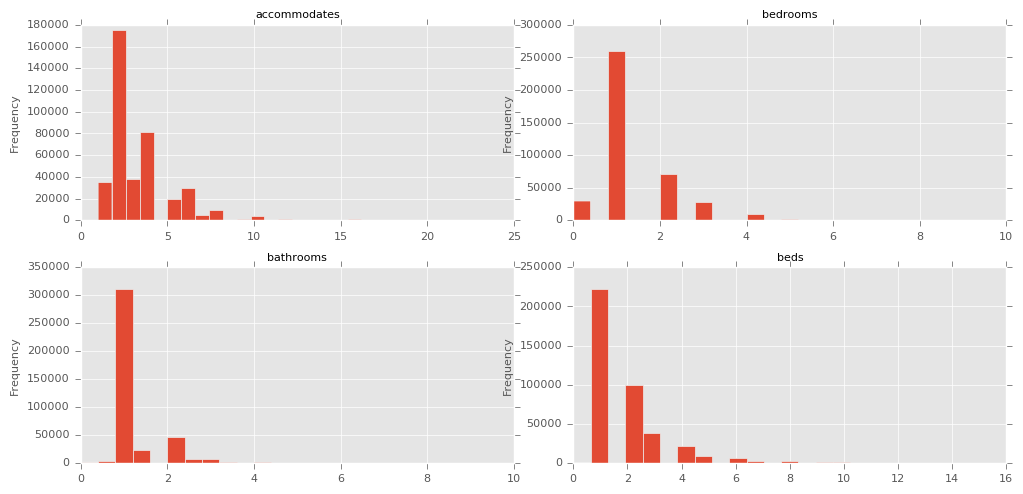

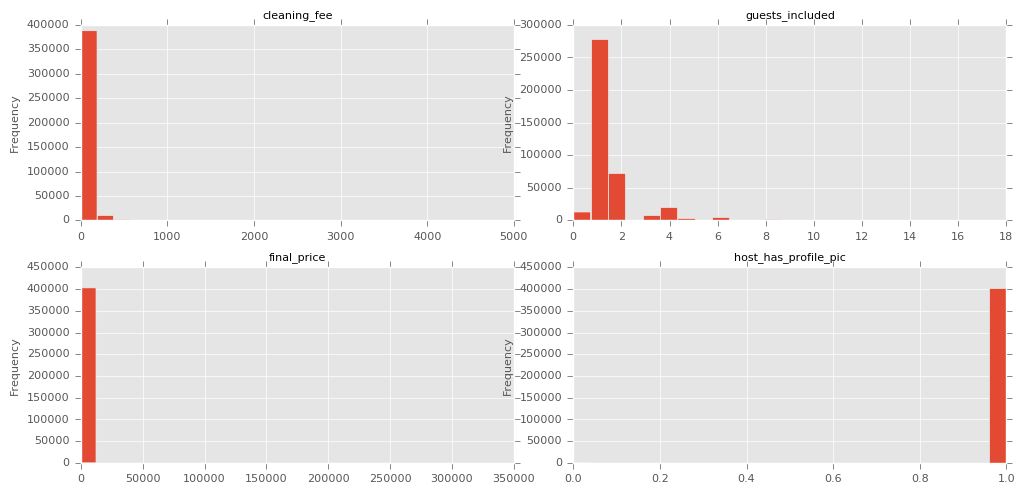

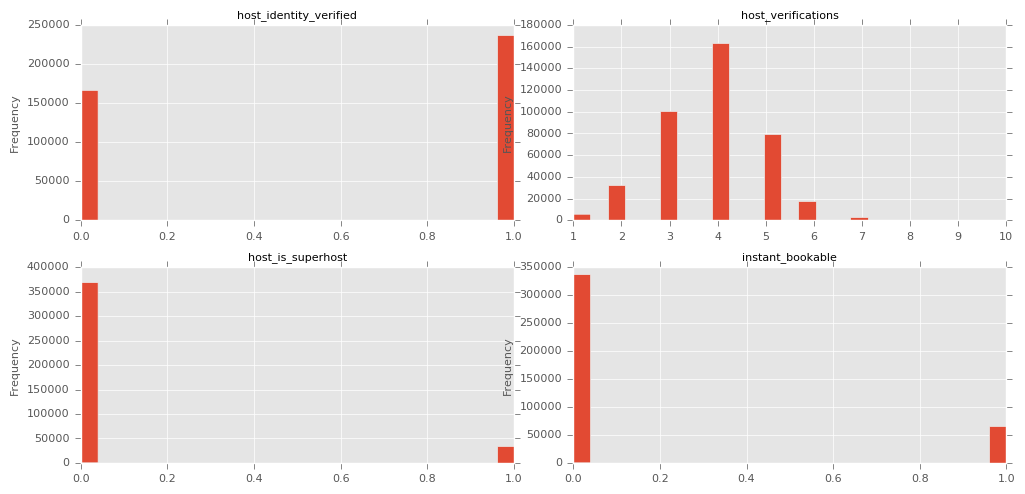

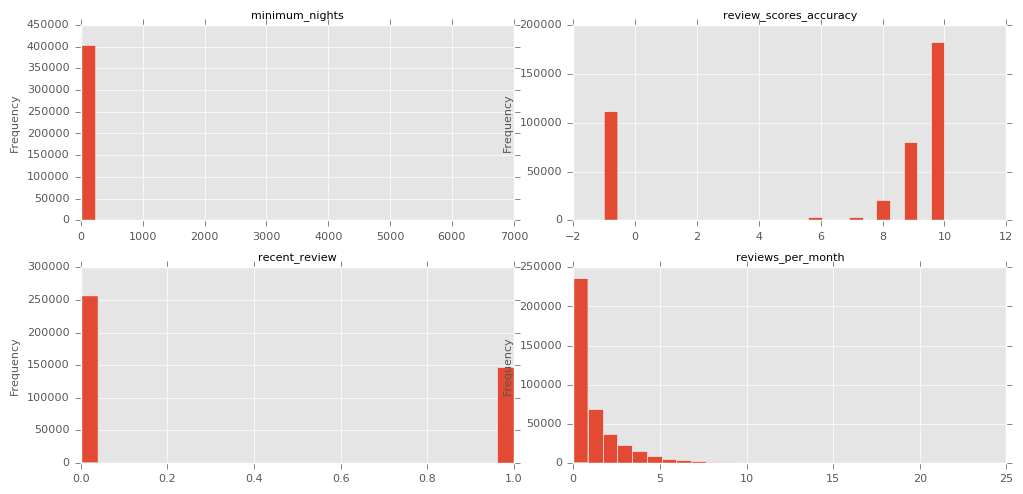

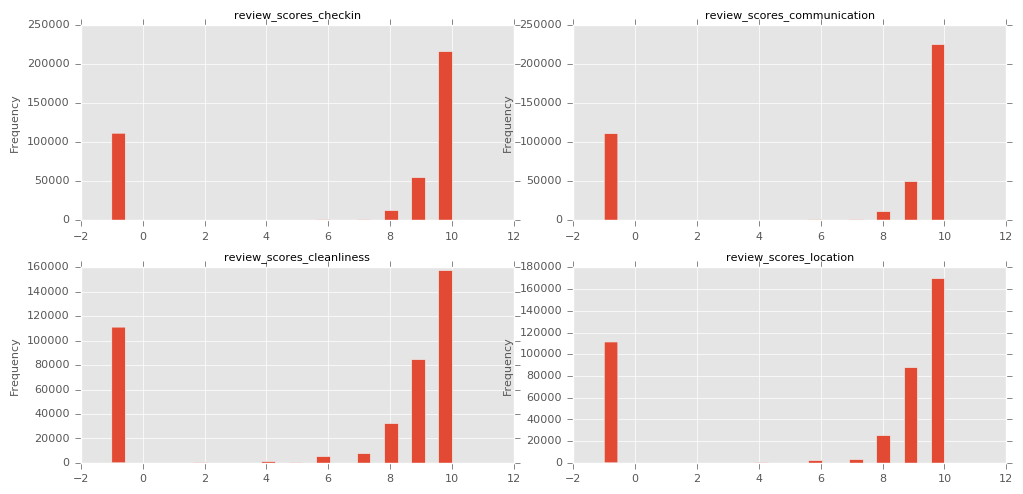

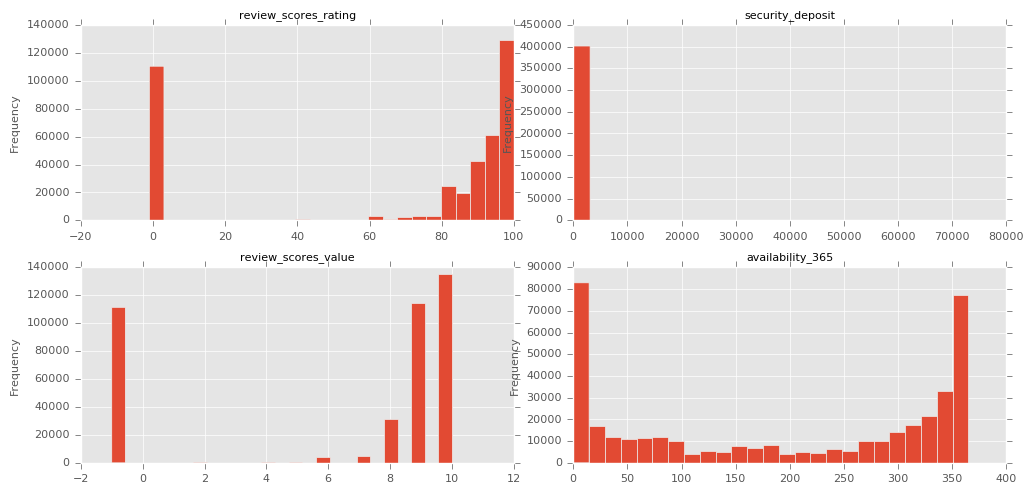

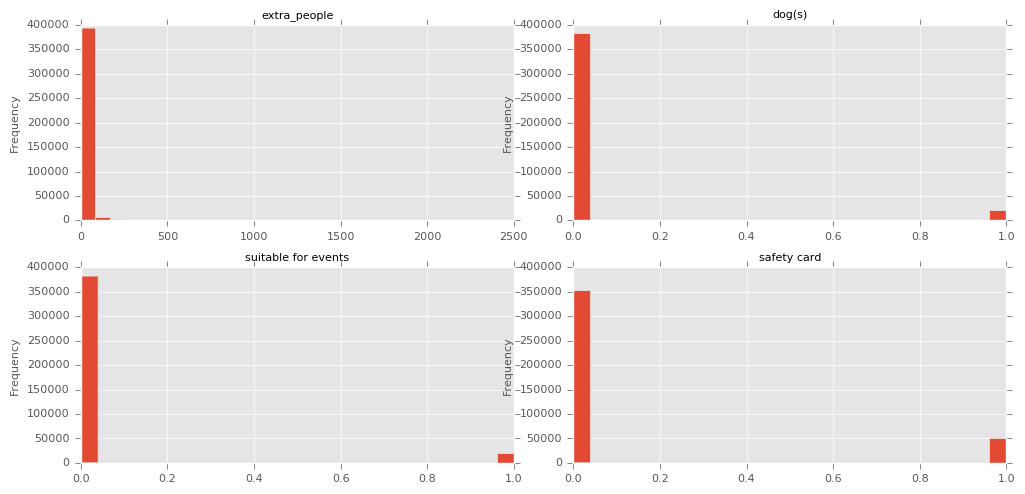

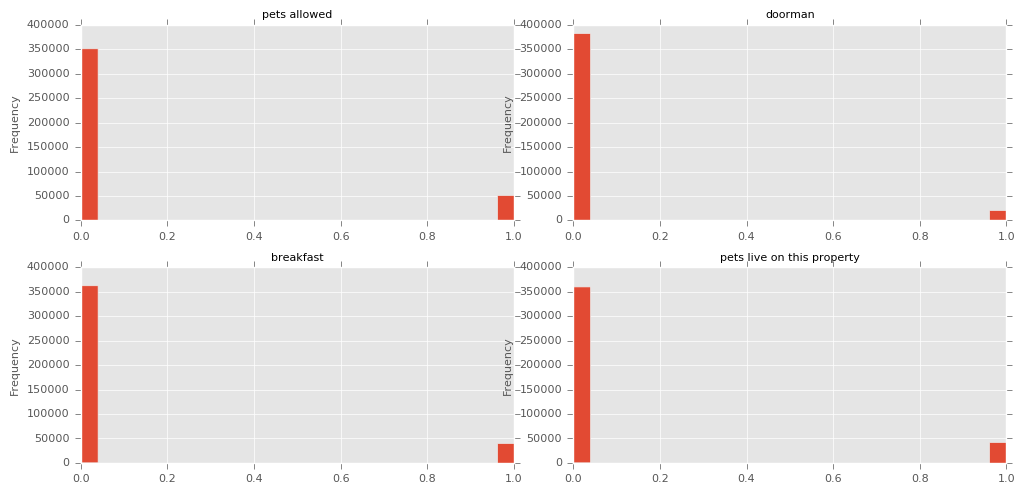

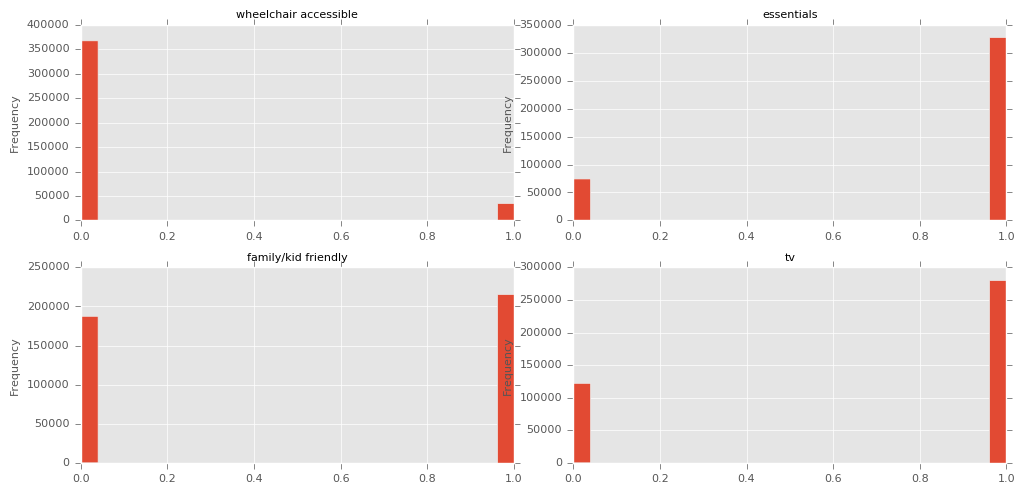

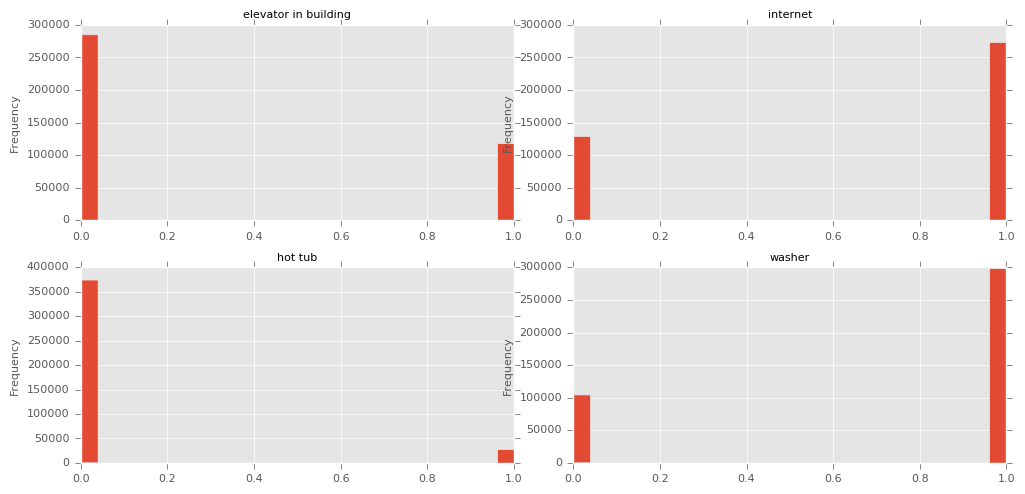

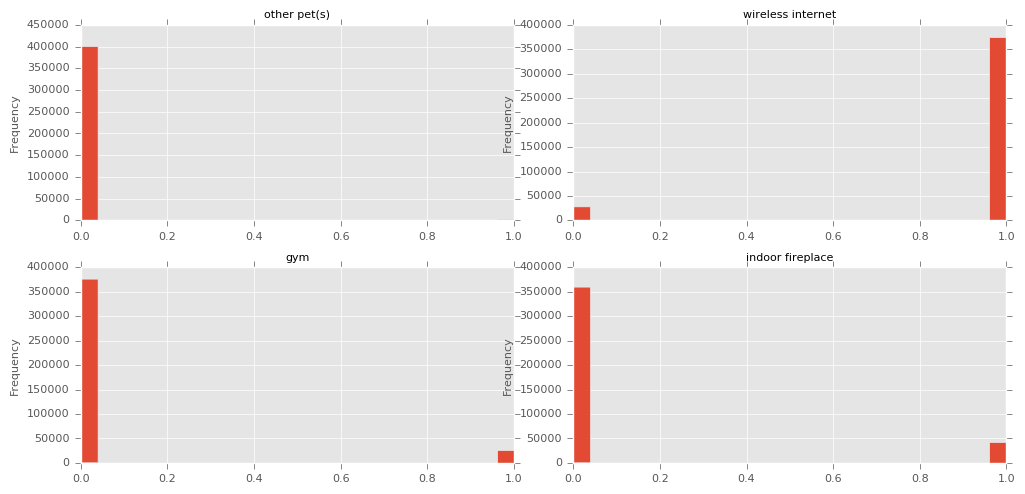

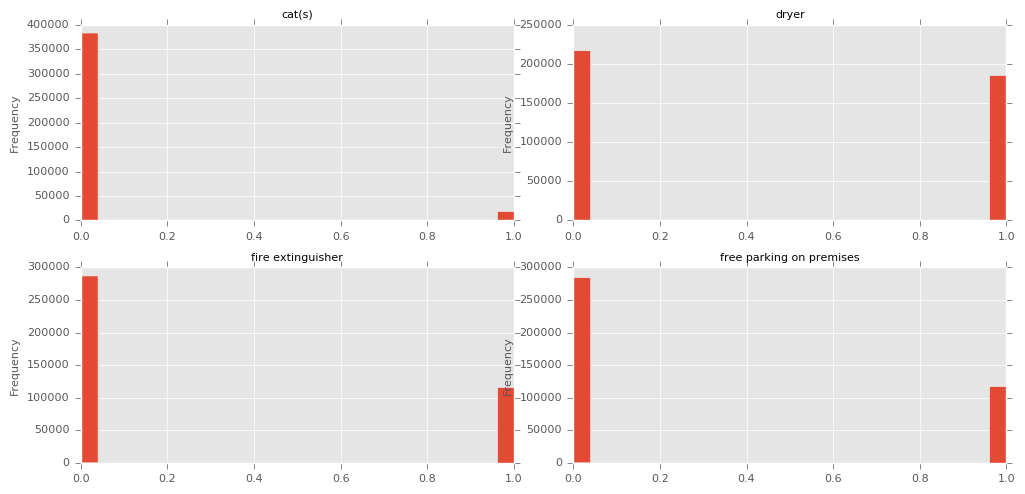

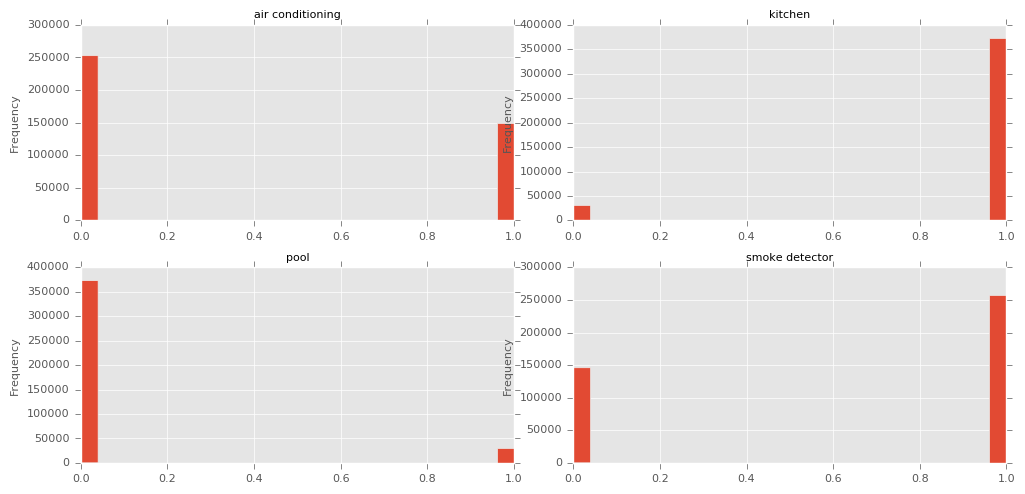

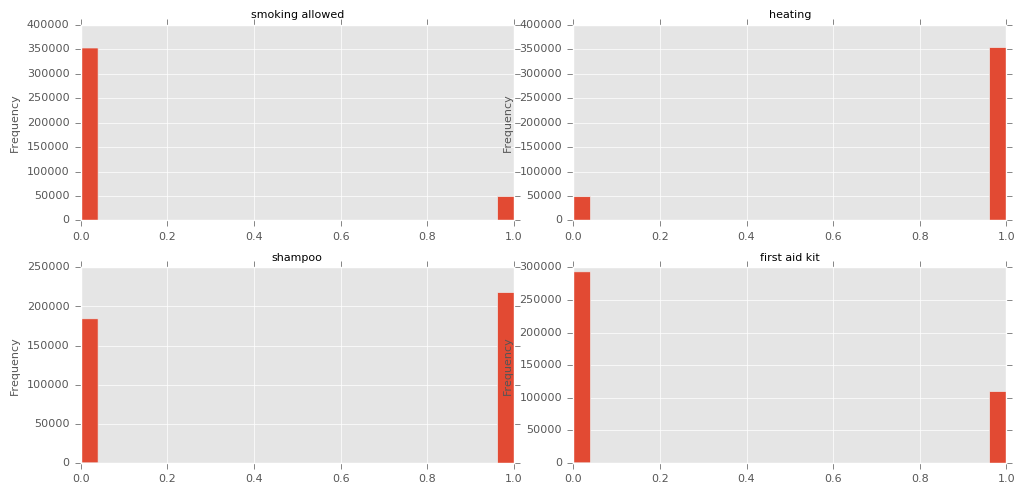

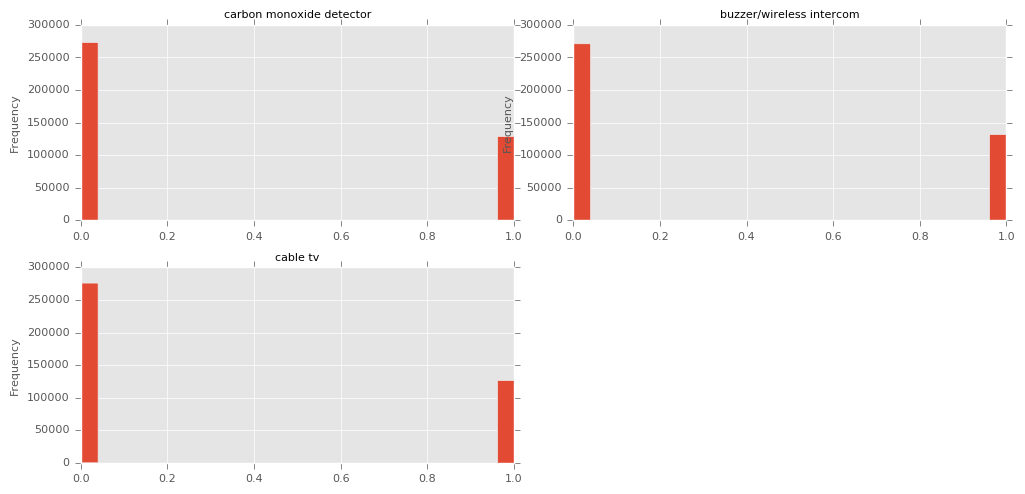

In [8]:
numeric_data = data[num_cols]
excluded_num = ['id', 'scrape_id']
plot_histograms(data=numeric_data, 
                var=[c for c in num_cols if c not in excluded_num], 
                path=None, 
                prefix=None, 
                nrows=2, 
                grid=4, 
                bins=25,
                fonts=8, 
                fig_size=(10, 5))

 Taking a quick glance at the column descriptions, we can observe:

* Most of the hosts have profile picture while just 2 thirds are verified. Just a few of them are superhosts.
* Accommodates, beds, bedrooms and bathrooms follow a reasonable distribution. We may find options with no bedrooms (e.g. studio, cabin) or no bathrooms, but it is not expected not to have a bed (even if the bed is not a traditional one).
* Cleaning fee seems to have outliers. We observe the same for the security deposit.
* Prices also seem to include very high values that we will consider as outliers.
* Number of maximum guests (accommodates) are mainly distributed between 0 and 6, but there are also lodgings offering up to 18 guests, which is a reasonable amount for large apartments.
* Host verifications range from 1 to 10, which is ok.
* Minimum number of nights also happen to contain outliers.
* Though there are some listings with very high number of reviews per month (up to 25), we regard this as a rare but feasible situation.
* Amenities seem to be reasonably distributed.
* Review columns have negative values when missing (non-rated). We see that listings are, on average, rated high (above 8 for specific scores and above 60 for overall rating).
* The price for extra people contain also high values (outliers).
* We see there are a high amount of listings that are either fully booked or barely busy.
* There are some listings which include no guests, which does not have non-sense.

Let's further observe those columns which seemed to contain outliers in the visualization.

#### Beds

We discard those instances that do not have any beds.

In [8]:
size_before = data.shape[0]
data = data[data['beds'] >= 1]
size_after = data.shape[0]
print('Eliminated %d instances out of %d after removing rows without beds'
     % (size_before - size_after, size_before))

Eliminated 26 instances out of 402820 after removing rows without beds


#### Cleaning fee

We just consider lodgings that have cleaning fees below 750 dollars.

In [9]:
size_before = data.shape[0]
data = data[data['cleaning_fee'] <= 500]
size_after = data.shape[0]
print('Eliminated %d instances out of %d after removing cleaning fees above 750 dollars'
     % (size_before - size_after, size_before))

Eliminated 1233 instances out of 402794 after removing cleaning fees above 750 dollars


#### Price

We saw that the 75 percentile of the prices is around 170 dollars while the maximum price recorded is above 300k dollars. It is also noticeable that there are prices around 0 that must be omitted. We decide to discard those prices below 20 dollars and above 1500. 

In [10]:
size_before = data.shape[0]
data = data[(data['final_price'] <= 1500) & (data['final_price'] >= 20)]
size_after = data.shape[0]
print('Eliminated %d instances out of %d after removing prices below 20 dollars and above 1500'
     % (size_before - size_after, size_before))

Eliminated 3917 instances out of 401561 after removing prices below 20 dollars and above 1500


#### Minimum nights

Since our project will focus on short-term lodging price prediction, we will restrict lodgings that have more than 30 days as minimum stay.

In [11]:
size_before = data.shape[0]
data = data[data['minimum_nights'] <= 30]
size_after = data.shape[0]
print('Eliminated %d instances out of %d after removing minimum stays above 30 days'
     % (size_before - size_after, size_before))

Eliminated 1353 instances out of 397644 after removing minimum stays above 30 days


#### Security deposit

Let's consider a maximum of 2000 dollars as security deposit.

In [12]:
size_before = data.shape[0]
data = data[data['security_deposit'] <= 2000]
size_after = data.shape[0]
print('Eliminated %d instances out of %d after removing security deposits above 2000 dollars'
     % (size_before - size_after, size_before))

Eliminated 3164 instances out of 396291 after removing security deposits above 2000 dollars


#### Guests included

Guests are the number of people that are included in the price. From that number to the maximum number (accommodates), an extra price (extra_people) is paid per person and night.

First, let's ensure that the number of guests never surpasses the number of accommodates:

In [13]:
size_before = data.shape[0]
data = data[data['guests_included'] <= data['accommodates']]
size_after = data.shape[0]
print('Eliminated %d instances out of %d after removing non-coherent guests feature'
     % (size_before - size_after, size_before))

Eliminated 2042 instances out of 393127 after removing non-coherent guests feature


The number of guests is the number of people the host includes in the price. Therefore, let's discard those entries containing no guests.

In [14]:
size_before = data.shape[0]
data = data[data['guests_included'] > 0]
size_after = data.shape[0]
print('Eliminated %d instances out of %d after removing entries without guests included'
     % (size_before - size_after, size_before))

Eliminated 12573 instances out of 391085 after removing entries without guests included


#### Extra people

The extra_people column contains the number of dollars to be paid for extra guests not included in the price.
Extra people price is not expected to be above the base price:

In [15]:
size_before = data.shape[0]
data = data[data['final_price'] >= data['extra_people']]
size_after = data.shape[0]
print('Eliminated %d instances out of %d after removing high extra people prices'
     % (size_before - size_after, size_before))

Eliminated 2037 instances out of 378512 after removing high extra people prices


### Scores

We have seen that most of the scores are distributes in a similar way: most of the values are top-scores or non-rated while 9 scores have considerable support and the other options have a very limited support. We decide to define 4 categories: very good (score of 10), good (score of 9), regular (less than 9) and non-rated for all scores between 0 and 10.

In [16]:
def categorize_score(score):
    """ Converts score into category considering the input bounds. Categories defined as: 
            - 10 is very good
            - 9 is good
            - below 9 is regular
            - Missing is non-rated
    """
    if score == -1:
        return "non-rated"
    else:
        if score == 10:
            return "very good"
        elif score == 9:
            return "good"
        elif score < 9:
            return "regular"

# Categorize scores in interval 0-10
review_10_scores = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value']
for c in review_10_scores:
    data.loc[:, c] = data[c].apply(categorize_score)

### Score rating

Let's now categorize the general score of the listing.

In [17]:
def categorize_rating(score):
    """ Converts rating into category considering the input bounds. Categories defined as: 
            - 95 < x <= 100: very good
            - 90 <= x <= 95: good
            - x < 90: regular
            - Missing is non-rated
    """
    if score == -1:
        return "non-rated"
    else:
        if score > 95:
            return "very good"
        elif score >= 90 and score <= 95:
            return "good"
        elif score < 90:
            return "regular"

col = 'review_scores_rating'
data.loc[:, col] = data[col].apply(categorize_rating)

## Categorical columns

Now it is time to analyse the categorical columns

In [24]:
def show_categorical(dataframe, cols, excluded_cols, normalized=False):
    """ Shows distribution of categories within each categorical feature """
    subset = dataframe[cols]
    for c in subset:
        if c not in excluded_cols:
            print('Counts for %s' % c)
            unique = subset[c].value_counts(normalize=normalized)
            print(unique)
            print('\n')

excluded_cat = ['listing_url', 'picture_url', 'last_scraped']
show_categorical(data, cat_cols, excluded_cat)

Counts for area
paris                48796
london               44639
new-york-city        38109
sydney               22035
los-angeles          21887
barcelona            15374
berlin               14353
amsterdam            13128
copenhagen           12799
melbourne            11485
toronto              11168
mallorca             10234
montreal              9866
san-francisco         8043
madrid                6620
san-diego             6016
dublin                5673
edinburgh             5584
austin                5468
hong-kong             4933
chicago               4881
vienna                4686
vancouver             4452
brussels              4410
new-orleans           4254
seattle               3650
washington-dc         3500
boston                3365
nashville             3145
portland              3098
venice                2777
denver                2329
northern-rivers       2263
geneva                2193
athens                1812
trentino              1780
victoria    

### Removing small cities

We observe that there are many cities with just a bunch of listings, which add sparsity to the resulting dataset without adding much information. Let's just use cities with more than 5000 listings.

In [25]:
city_counts = data['area'].value_counts(normalize=False)
big_cities = city_counts[city_counts > 5000].index
data = data[data['area'].isin(big_cities)]
print('List of resulting cities({}): {}'.format(len(big_cities), data['area'].unique().tolist()))

List of resulting cities(19): ['san-diego', 'edinburgh', 'madrid', 'toronto', 'dublin', 'mallorca', 'new-york-city', 'amsterdam', 'sydney', 'london', 'san-francisco', 'los-angeles', 'copenhagen', 'berlin', 'paris', 'austin', 'barcelona', 'melbourne', 'montreal']


Let's see now how data categorical data is distributed

In [26]:
show_categorical(data, cat_cols, excluded_cat)

Counts for area
paris            48796
london           44639
new-york-city    38109
sydney           22035
los-angeles      21887
barcelona        15374
berlin           14353
amsterdam        13128
copenhagen       12799
melbourne        11485
toronto          11168
mallorca         10234
montreal          9866
san-francisco     8043
madrid            6620
san-diego         6016
dublin            5673
edinburgh         5584
austin            5468
Name: area, dtype: int64


Counts for bed_type
Real Bed         297895
Pull-out Sofa      7803
Futon              2764
Couch              1851
Airbed              964
Name: bed_type, dtype: int64


Counts for subarea
Buttes-Montmartre                 5635
Sydney                            5198
Tower Hamlets                     4809
Popincourt                        4584
Dublin City                       4488
Westminster                       4469
Hackney                           4268
Waverley                          3822
Williamsburg      

### Reducing sparsity

There are many identifiers that are very little supported in the data. As an example, we can see how no_refunds, long_term or super strict cancelation policies have very few instances. We are going to merge those categories in columns to represent a new category which is already not represented by the other ones. 

In [27]:
def aggregate_categories(data, column, minimum_support, new_category):
    """ Converts those categories with support below threshold into a new category """
    counts = data[column].value_counts(normalize=True)
    values = counts[counts < minimum_support].index
    data.loc[data[column].isin(values), column] = new_category
    return data

data = aggregate_categories(data, 'cancellation_policy', 0.001, 'other')

Let's do the same for the property types, discarding those below 200 instances.

In [28]:
data = aggregate_categories(data, 'property_type', 0.001, 'Other')

Finally we have should apply this logic for the subareas (neighbourhood). Let's keep those who have at least 0.01% of instances and set the rest to "Other".

In [29]:
subareas_before = len(data['subarea'].unique())
data = aggregate_categories(data, 'subarea', 0.0001, 'Other')
subareas_after = len(data['subarea'].unique())
print('Before we had %d neighbourhoods and now we have %d' % (subareas_before, subareas_after))

Before we had 1416 neighbourhoods and now we have 752


Before saving the final version of the dataset, let's have another general look at the data.

In [30]:
data.describe(include='all')

id   accommodates    area      bathrooms  bed_type  \
count   3.112770e+05  311277.000000  311277  311277.000000    311277   
unique           NaN            NaN      19            NaN         5   
top              NaN            NaN   paris            NaN  Real Bed   
freq             NaN            NaN   48796            NaN    297895   
mean    7.968635e+06       3.211644     NaN       1.225776       NaN   
std     4.560230e+06       1.971584     NaN       0.562765       NaN   
min     6.000000e+00       1.000000     NaN       0.000000       NaN   
25%     4.241954e+06       2.000000     NaN       1.000000       NaN   
50%     7.808194e+06       2.000000     NaN       1.000000       NaN   
75%     1.209828e+07       4.000000     NaN       1.000000       NaN   
max     1.629417e+07      18.000000     NaN       8.000000       NaN   

             bedrooms           beds cancellation_policy   cleaning_fee  \
count   311277.000000  311277.000000              311277  311277.000000   
unique            NaN            NaN                   4            NaN   
top               NaN            NaN              strict            NaN   
freq              NaN            NaN              120154            NaN   
mean         1.346987       1.855161                 NaN      35.875394   
std          0.900802       1.409482                 NaN      55.107698   
min          0.000000       1.000000                 NaN       0.000000   
25%          1.000000       1.000000                 NaN       0.000000   
50%          1.000000       1.000000                 NaN      20.000000   
75%          2.000000       2.000000                 NaN      50.000000   
max         10.000000      16.000000                 NaN     500.000000   

              country    final_price  guests_included  host_has_profile_pic  \
count          311277  311277.000000    311277.000000         311277.000000   
unique             10            NaN              NaN                   NaN   
top     united-states            NaN              NaN                   NaN   
freq            79523            NaN              NaN                   NaN   
mean              NaN     148.487836         1.490688              0.996829   
std               NaN     169.700102         1.103089              0.056221   
min               NaN      20.000000         1.000000              0.000000   
25%               NaN      59.977961         1.000000              1.000000   
50%               NaN      95.000000         1.000000              1.000000   
75%               NaN     160.863128         2.000000              1.000000   
max               NaN    1500.000000        18.000000              1.000000   

        host_identity_verified  host_is_superhost  host_verifications  \
count            311277.000000      311277.000000       311277.000000   
unique                     NaN                NaN                 NaN   
top                        NaN                NaN                 NaN   
freq                       NaN                NaN                 NaN   
mean                  0.579140           0.074143            3.813382   
std                   0.493698           0.262004            1.049816   
min                   0.000000           0.000000            1.000000   
25%                   0.000000           0.000000            3.000000   
50%                   1.000000           0.000000            4.000000   
75%                   1.000000           0.000000            4.000000   
max                   1.000000           1.000000           10.000000   

        instant_bookable last_scraped                           listing_url  \
count      311277.000000       311277                                311277   
unique               NaN           20                                311277   
top                  NaN   2016-10-03  https://www.airbnb.com/rooms/1262053   
freq                 NaN        44639                                     1   
mean            0.161711       

In [31]:
show_categorical(data, cat_cols, excluded_cat)

Counts for area
paris            48796
london           44639
new-york-city    38109
sydney           22035
los-angeles      21887
barcelona        15374
berlin           14353
amsterdam        13128
copenhagen       12799
melbourne        11485
toronto          11168
mallorca         10234
montreal          9866
san-francisco     8043
madrid            6620
san-diego         6016
dublin            5673
edinburgh         5584
austin            5468
Name: area, dtype: int64


Counts for bed_type
Real Bed         297895
Pull-out Sofa      7803
Futon              2764
Couch              1851
Airbed              964
Name: bed_type, dtype: int64


Counts for subarea
Other                         7518
Buttes-Montmartre             5635
Sydney                        5198
Tower Hamlets                 4809
Popincourt                    4584
Dublin City                   4488
Westminster                   4469
Hackney                       4268
Waverley                      3822
Williamsburg   

Finally let's visualize the distribution of the prices

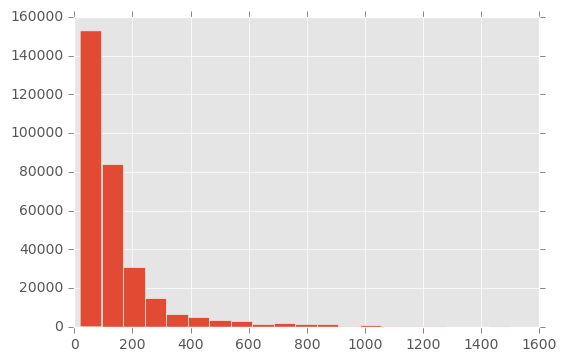

In [33]:
data['final_price'].hist(bins=20)

And the anual availability of the listings:

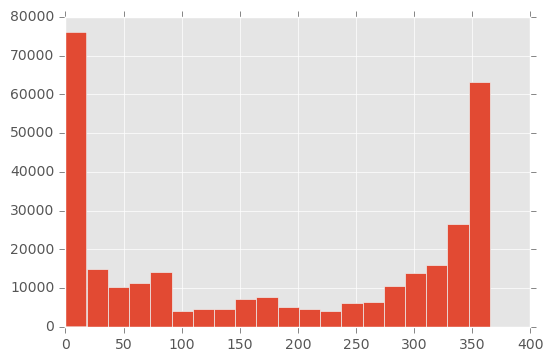

In [34]:
data['availability_365'].hist(bins=20)

Now we save the final version of the dataset into a csv file.

In [35]:
print('Final dataset contains %d instances and %d columns' % (data.shape[0], data.shape[1]))
data.to_csv(AIRBNB_FINAL, index=False)

Final dataset contains 311277 instances and 72 columns
